# Coursework 2: Image Classification

In this coursework, we are going to develop a neural network model for for image classification.

What to do?

* The coursework includes both coding questions and written questions. Please read both the text and code comment in this notebook to get an idea what you are supposed to implement.

* First, run `jupyter-lab` or `jupyter-notebook` in the terminal to start the Jupyter notebook.

* Then, complete and run the code to get the results.

* Finally, please export (File | Export Notebook As...) or print (using the print function of your browser) the notebook as a pdf file, which contains your code, results and answers, and upload the pdf file onto Cate.

Dependencies:

* If you work on a college computer in the Computer Lab, where Ubuntu 18.04 is installed by default, you can use the following virtual environment for your work, where required Python packages are already installed.

`source /vol/bitbucket/wbai/virt/computer_vision_2020/bin/activate`

When you no longer need the virtual environment, you can exit it by running `deactivate`.

* If you work on your own laptop using either Anaconda or plain Python, you can install new packages (such as numpy, imageio etc) running `conda install [package_name]` or `pip3 install [package_name]` in the terminal.

In [1]:
# Import libraries (provided)
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.image as mpimg

# 1. Load and visualise data. (25 marks)

Throughout this coursework. you will be working with the Fashion-MNIST dataset. If you are interested, you may find information about the dataset in this paper.

[1] Han Xiao, Kashif Rasul, Roland Vollgraf. Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747)

The dataset is prepared in a similar way to MNIST. It is split into a set of 60,000 training images and a set of 10,000 test images. The images are of size 28x28 pixels.

There are in total 10 label classes, which are:
* 0: T-shirt/top
* 1: Trousers
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

In [2]:
# Load data (provided)
train_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=True)
train_image = np.array(train_set.data)
train_label = np.array(train_set.targets)
class_name = train_set.classes

test_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=False)
test_image = np.array(test_set.data)
test_label = np.array(test_set.targets)

### 1.1 Display the dimension of the training and test sets. (5 marks)

In [3]:
print("Train Images shape: ", train_image.shape)
print("Test Image shape: ", test_image.shape)


Train Images shape:  (60000, 28, 28)
Test Image shape:  (10000, 28, 28)


### 1.2 Visualise sample images for each of the 10 classes. (10 marks)

Please plot 10 rows x 10 columns of images. Each row shows 10 samples for one class. For example, row 1 shows 10 `T-shirt/top` images, row 2 shows 10 `Trousers` images.

In [4]:
plt.figure(figsize=(140,140))
rows = [0] * 10
i = 0
while all(row < 10 for row in rows) or i < 60000:
    label = train_label[i]
    if rows[label] < 10:
        rows[label] += 1
        plt.subplot(10, 10, label * 10 + rows[label])
        plt.imshow(train_image[i], cmap="gray")
    i += 1


### 1.3 Display the number of training samples for each class. (5 marks)

In [5]:
for i in range(len(class_name)):
    print("%s: %d" % (class_name[i], np.sum(train_label == i)))
    

T-shirt/top: 6000
Trouser: 6000
Pullover: 6000
Dress: 6000
Coat: 6000
Sandal: 6000
Shirt: 6000
Sneaker: 6000
Bag: 6000
Ankle boot: 6000


### 1.4 Discussion. (5 marks)
Is the dataset balanced? What would happen for the image classification task if the dataset is not balanced? 

Yes. Each class has the same amount of samples. 
If this was not the case, the neural network might be more keen to classify 
a new image as a class that it has trained more times on. 

## 2. Image classification. (60 marks)

### 2.1 Build a convolutional neural network using the `PyTorch` library to perform classification on the Fashion-MNIST dataset. (15 marks)

You can use a network architecture similar to LeNet (shown below), which consists a number of convolutional layers and a few fully connected layers at the end.

![](lenet.png)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        C1 = nn.Conv2d(1, 6, 5, padding=2) # (N x  1 x 28 x 28) ==> (N x   6 x 28 x 28)
        S2 = nn.MaxPool2d(2, stride = 2)   # (N x  6 x 28 x 28) ==> (N x   6 x 14 x 14)
        C3 = nn.Conv2d(6, 16, 5)           # (N x  6 x 14 x 14) ==> (N x  16 x 10 x 10)
        S4 = nn.MaxPool2d(2, stride = 2)   # (N x 16 x 10 x 10) ==> (N x  16 x  5 x  5)
        C5 = nn.Conv2d(16, 120, 5)         # (N x 16 x  5 x  5) ==> (N x 120 x  1 x  1)

        self.convnet = nn.Sequential(
                            C1, nn.ReLU(), 
                            S2, 
                            C3, nn.ReLU(), 
                            S4, 
                            C5, nn.ReLU()
                        )

        F6 = nn.Linear(120, 84) 
        F7 = nn.Linear(84, 10)

        self.fc = nn.Sequential(
                            F6, nn.ReLU(), 
                            F7, nn.LogSoftmax(dim=-1)
                        )

    def forward(self, x):
        out = self.convnet(x)
        out = out.view(x.size(0), -1)
        out = self.fc(out)
        return out



### 2.2 Define the loss function, optimiser and hyper-parameters such as the learning rate, number of iterations, batch size etc. (5 marks)

In [79]:

net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
batch = 128
epochs = 6


### 2.3 Start model training. (20 marks)

At each iteration, get a random batch of images and labels from train_image and train_label, convert them into torch tensors, feed into the network model and perform gradient descent. Please also evaluate how long it takes for training.

epoch 0 starting...
epoch 1 starting...
epoch 2 starting...
epoch 3 starting...
epoch 4 starting...
epoch 5 starting...
Finished Training in 53.84 seconds


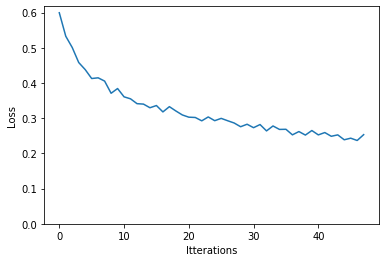

In [80]:
smoothness = 50

losses = []
plotLosses = []
start_time = time.time()
for epoch in range(epochs):  # loop over the dataset multiple times
    perms = np.random.permutation(len(train_image))
    print("epoch %d starting..." % epoch)

    num_of_loops = len(train_image) // batch
    for i in range(num_of_loops):
        start_index = i * batch
        end_index = min((i + 1) * batch, len(train_image))

        labels = torch.LongTensor(train_label[start_index:end_index])
        data = torch.LongTensor(train_image[start_index:end_index].reshape(batch,1,28,28))

        optimizer.zero_grad()

        outputs = net(data.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.detach().cpu().item())
        if i % smoothness == 0 and i > smoothness: 
            plotLosses.append(sum(losses[-smoothness:])/smoothness)


time_taken = time.time() - start_time 
print('Finished Training in %.2f seconds' % time_taken)

f, ax = plt.subplots(1)
ax.plot(plotLosses)
ax.set_ylim(bottom=0)
ax.set_xlabel("Itterations")
ax.set_ylabel("Loss")
plt.show(f)  


### 2.4 Deploy the trained model onto the test set. (10 marks)
Please also evaluate how long it takes for testing.

In [81]:

reshaped_test_images = torch.Tensor(test_image.reshape(10000, 1, 28, 28))

out = net.forward(reshaped_test_images)
_, labels = torch.max(out, dim = 1)
labels = labels.numpy()

### 2.5 Evaluate the classification accuracy on the test set. (5 marks)

In [82]:
correct = 0
for i, label in enumerate(labels):
    if label == test_label[i]:
        correct += 1
percent = (correct / len(labels)) * 100
print("Accuracy: %.2f%%" % percent  )

Accuracy: 88.30%


### 2.6 Print out and visualise the confusion matrix. (5 marks)
You can use relevant functions in [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [83]:
metrics.confusion_matrix(labels, test_label)

array([[917,   4,  24,  36,   3,   0, 238,   0,   4,   0],
       [  2, 972,   1,  10,   0,   0,   0,   0,   1,   0],
       [  9,   0, 811,   3,  60,   0,  85,   0,   0,   0],
       [ 17,  17,  10, 890,  28,   0,  24,   0,   3,   0],
       [  4,   4, 112,  37, 876,   0, 107,   0,   4,   0],
       [  2,   0,   0,   0,   0, 949,   0,   1,   2,  11],
       [ 41,   1,  35,  16,  22,   0, 515,   0,   0,   0],
       [  1,   0,   0,   0,   0,  37,   0, 950,   6,  19],
       [  7,   2,   7,   8,  11,   2,  31,   1, 980,   0],
       [  0,   0,   0,   0,   0,  12,   0,  48,   0, 970]])

## 3. Deploy in real world. (15 marks)

Take 3 photos that belongs to the 10 classes (e.g. clothes, shoes) in your real life. Use either Python or other software (Photoshop, Gimp etc) to convert the photos into grayscale, negate the intensities so that background becomes black or dark, crop the region of interest and reshape into the size of 28x28.

### 3.1 Load and visualise your own images (5 marks)

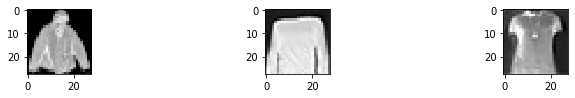

In [84]:

plt.figure(figsize=(14*3, 14))

for i in range(3):
    try:
        img = mpimg.imread('MyTestNet/%s.jpg' % (i + 1))
        plt.subplot(10, 10, i+1)
        plt.imshow(img, cmap="gray")
    except:
        pass




### 3.2 Test your network on the real images and display the classification results. (5 marks)

In [85]:
exp_labels = [4, 2, 0]

for i in range(3):
        img = mpimg.imread('MyTestNet/%s.jpg' % (i + 1))
        img = torch.Tensor(img.reshape(1, 1, 28, 28))

        out = net.forward(img)
        _, labels = torch.max(out, dim = 1)

        print("Expected: %s, Predicted: %s" % (class_name[exp_labels[i]], class_name[labels[0]]))

Expected: Coat, Predicted: Coat
Expected: Pullover, Predicted: Pullover
Expected: T-shirt/top, Predicted: T-shirt/top


### 3.3 Discuss the classification results. (5 marks)

Does the model work? Is there anyway to improve the real life performance of the model?

My model predicted my pictures correctly, and with a 88% accuracy, it seems pretty good. By using a larger data set, and experiment more with the batch sizes, we could get a better performance.